In [806]:
import numpy as np
import seaborn as sns
import re
import pandas as pd
import os

Here is the post-processing notebook. As of writing this, the code only exports a txt file "highestXPos.txt". The file contains the highestXPos at each frame, with each line in the text file being a single frame. This notebook serves as a "sketchbook" for post-processing, before it is written in the napari plugin.

Ideas:
- ~~Trim the data after towards the end (after smoothing, etc.)~~ I want to benchmark the average speed at each step so I have to do this step first now
- Variable names will be like the steps taken (e.g. smoothed twice = "dataSmoothSmooth", smoothed then cropped = "dataSmoothCrop")

In [807]:
dataFolder = "/Users/kyle/Desktop/ros_benchmark/DSC_0201_Test_No_250"
thermoCoupleDataFolder = "/Users/kyle/Library/CloudStorage/Box-Box/ROS_Experiments_Data_Folder/CSV file data"

# Import highestXPos.txt and preview it
data = np.loadtxt(dataFolder + "/highestXPos.txt")

In [808]:
# Extract test string from filename
# Use regex to extract, e.g. "Test_No_250" from "DSC_0201_Test_No_250"
testString = re.search(r"Test_No_\d+", dataFolder).group(0)
print(testString)

# Get thermocouple data
# thermocouple_location(cm),Ignition_time(sec),Middle_points(cm),ROS(cm/sec)
thermoCoupleData = pd.read_csv(
    os.path.join(thermoCoupleDataFolder, f"{testString}_ROS_output.csv")
)

Test_No_250


<Axes: >

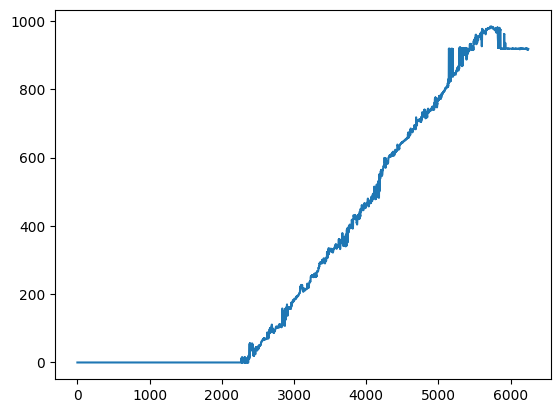

In [809]:
# Plot data
sns.lineplot(data=data)

In [810]:
# Get the max index
maxIndex = data.argmax()

# Get the first index where there is a value above zero
firstIndex = np.where(data > 0)[0][0]

# TODO: Make sure to check weird edge cases
dataTrim = data[firstIndex:maxIndex]

<Axes: >

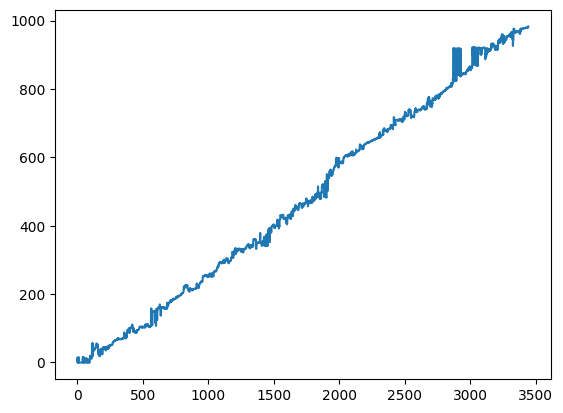

In [811]:
# Plot dataTrim
sns.lineplot(data=dataTrim)

<Axes: >

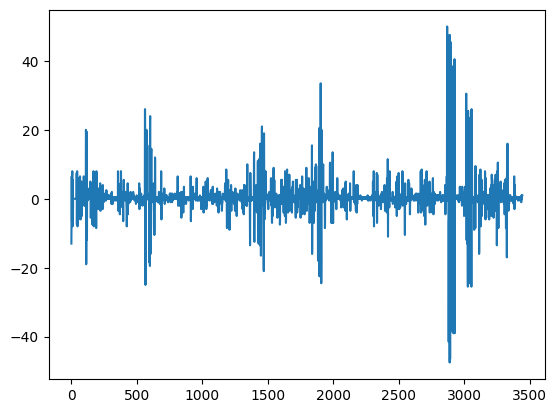

In [812]:
# Get the gradient
dataTrimGradient = np.gradient(dataTrim)

# Plot dataTrimGradient
sns.lineplot(data=dataTrimGradient)

In [813]:
# Get the average speed
dataTrimGradientAvgSpeed = np.average(dataTrimGradient)
print(dataTrimGradientAvgSpeed)

0.2797446314567615


In [814]:
# Smooth data with moving average
# (what MATLAB's smoothdata() does)
# TODO: I don't know the window matlab uses
window = 100
dataTrimSmooth = np.convolve(dataTrim, np.ones(window), 'valid') / window

<Axes: >

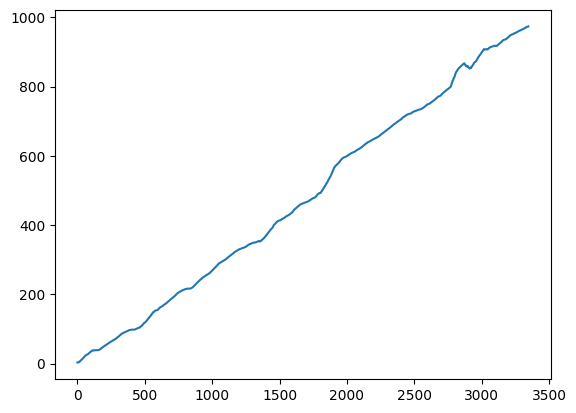

In [815]:
# Plot smoothed data
sns.lineplot(data=dataTrimSmooth)

<Axes: >

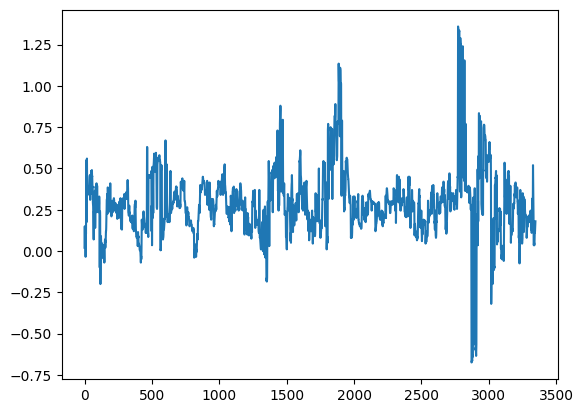

In [816]:
# Get the gradient
dataTrimSmoothGradient = np.gradient(dataTrimSmooth)

# Plot dataTrimSmoothGradient
sns.lineplot(data=dataTrimSmoothGradient)

In [817]:
# Get the average speed
dataTrimSmoothGradientAvgSpeed = np.average(dataTrimSmoothGradient)
print(dataTrimSmoothGradientAvgSpeed)

0.2898237227367792


In [818]:
print("Without smoothing:", dataTrimGradientAvgSpeed)
print("   With smoothing:", dataTrimSmoothGradientAvgSpeed)
print("")
print("Difference:", dataTrimSmoothGradientAvgSpeed - dataTrimGradientAvgSpeed)

Without smoothing: 0.2797446314567615
   With smoothing: 0.2898237227367792

Difference: 0.010079091280017716


# Plot against thermocouple data

In [819]:
# Create pd dataframe from dataTrim, frame number vs. highestXPos.
# Create frame numbers list from dataTrim.
lengthOfDataset = len(dataTrimSmooth)
frameNumbers = np.arange(0, lengthOfDataset)

# TODO: Why does dataTrimSmooth have less length?
dataTrimPd = pd.DataFrame({"frame": frameNumbers, "highestXPos": dataTrim[:lengthOfDataset], "highestXPosSmooth": dataTrimSmooth, "ros": dataTrimGradient[:lengthOfDataset], "rosUsingSmoothXPos": dataTrimSmoothGradient[:lengthOfDataset]})
dataTrimPd.head()

,frame,highestXPos,highestXPosSmooth,ros,rosUsingSmoothXPos
0,0,13.0,3.43,-13.0,0.020
1,1,0.0,3.45,-6.5,0.085
2,2,0.0,3.60,6.5,0.150
3,3,13.0,3.75,6.5,0.090
4,4,13.0,3.78,-6.5,0.030


In [820]:
# Convert frame column to seconds.
# The videos are 59.94 fps.

fps = 59.94
dataTrimPd["seconds"] = dataTrimPd['frame'] / fps

# Convert pixels to cm
# Currently the highestXPos column is in pixels.

# 104 pixels = 4.5cm
pixelsInUnit = 104
unitCm = 4.5

# pixels -> cm
dataTrimPd['highestXPosCm'] = dataTrimPd['highestXPos'] / pixelsInUnit * unitCm
dataTrimPd['highestXPosSmoothCm'] = dataTrimPd['highestXPosSmooth'] / pixelsInUnit * unitCm

# pixels/frame -> cm/s
dataTrimPd['rosCm'] = dataTrimPd['ros'] * (unitCm / pixelsInUnit) * fps
dataTrimPd['rosUsingSmoothXPosCm'] = dataTrimPd['rosUsingSmoothXPos'] * (unitCm / pixelsInUnit) * fps

dataTrimPd

,frame,highestXPos,highestXPosSmooth,ros,rosUsingSmoothXPos,seconds,highestXPosCm,highestXPosSmoothCm,rosCm,rosUsingSmoothXPosCm
0,0,13.0,3.43,-13.0,0.020,0.000000,0.562500,0.148413,-33.716250,0.051871
1,1,0.0,3.45,-6.5,0.085,0.016683,0.000000,0.149279,-16.858125,0.220452
2,2,0.0,3.60,6.5,0.150,0.033367,0.000000,0.155769,16.858125,0.389034
3,3,13.0,3.75,6.5,0.090,0.050050,0.562500,0.162260,16.858125,0.233420
4,4,13.0,3.78,-6.5,0.030,0.066733,0.562500,0.163558,-16.858125,0.077807
...,...,...,...,...,...,...,...,...,...,...
3342,3342,969.0,972.80,-0.5,0.110,55.755756,41.927885,42.092308,-1.296779,0.285291
3343,3343,968.0,972.91,-1.0,0.120,55.772439,41.884615,42.097067,-2.593558,0.311227
3344,3344,967.0,973.04,-1.5,0.140,55.789122,41.841346,42.102692,-3.890337,0.363098
3345,3345,965.0,973.19,-1.0,0.165,55.805806,41.754808,42.109183,-2.593558,0.427937


In [821]:
# Now join everything
# Round your time columns to the nearest tenth of seconds
dataTrimPd['seconds_rounded'] = dataTrimPd['seconds'].apply(lambda x: np.round(x * 10) / 10)
thermoCoupleData['Ignition_time_rounded'] = thermoCoupleData['Ignition_time(sec)'].apply(lambda x: np.round(x * 10) / 10)

# Merge the dataframes on the rounded time columns
merged_df = pd.merge(dataTrimPd, thermoCoupleData, left_on='seconds_rounded', right_on='Ignition_time_rounded', how='outer')

merged_df

,frame,highestXPos,highestXPosSmooth,ros,rosUsingSmoothXPos,seconds,highestXPosCm,highestXPosSmoothCm,rosCm,rosUsingSmoothXPosCm,seconds_rounded,thermocouple_location(cm),Ignition_time(sec),Middle_points(cm),ROS(cm/sec),Ignition_time_rounded
0,0,13.0,3.43,-13.0,0.020,0.000000,0.562500,0.148413,-33.716250,0.051871,0.0,0.0,0.0,6.75,0.87,0.0
1,1,0.0,3.45,-6.5,0.085,0.016683,0.000000,0.149279,-16.858125,0.220452,0.0,0.0,0.0,6.75,0.87,0.0
2,2,0.0,3.60,6.5,0.150,0.033367,0.000000,0.155769,16.858125,0.389034,0.0,0.0,0.0,6.75,0.87,0.0
3,3,13.0,3.75,6.5,0.090,0.050050,0.562500,0.162260,16.858125,0.233420,0.1,NaN,NaN,NaN,NaN,NaN
4,4,13.0,3.78,-6.5,0.030,0.066733,0.562500,0.163558,-16.858125,0.077807,0.1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3342,3342,969.0,972.80,-0.5,0.110,55.755756,41.927885,42.092308,-1.296779,0.285291,55.8,NaN,NaN,NaN,NaN,NaN
3343,3343,968.0,972.91,-1.0,0.120,55.772439,41.884615,42.097067,-2.593558,0.311227,55.8,NaN,NaN,NaN,NaN,NaN
3344,3344,967.0,973.04,-1.5,0.140,55.789122,41.841346,42.102692,-3.890337,0.363098,55.8,NaN,NaN,NaN,NaN,NaN
3345,3345,965.0,973.19,-1.0,0.165,55.805806,41.754808,42.109183,-2.593558,0.427937,55.8,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Test_No_250 \n 104px per 4.5cm')

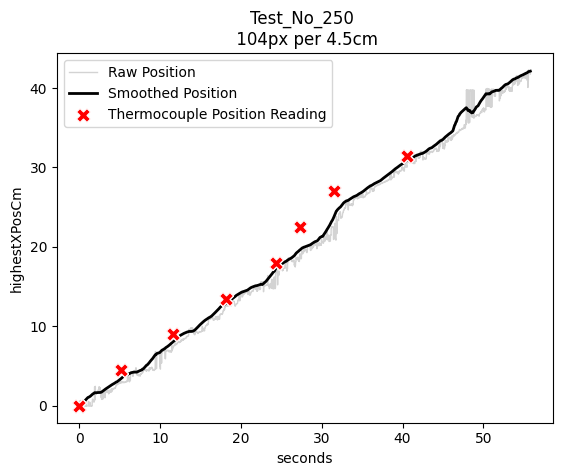

In [822]:
posComparison = sns.lineplot(merged_df, x="seconds", y="highestXPosCm", color="lightgrey", linewidth=1, label="Raw Position")
posComparison = sns.lineplot(merged_df, x="seconds", y="highestXPosSmoothCm", color="black", linewidth=2, label="Smoothed Position")
posComparison = sns.scatterplot(merged_df, x="Ignition_time(sec)", y="thermocouple_location(cm)", color="red", marker="X", s=100, zorder=10, label="Thermocouple Position Reading")

posComparison.set_title(f"{testString} \n {pixelsInUnit}px per {unitCm}cm")

(-2.0, 2.0)

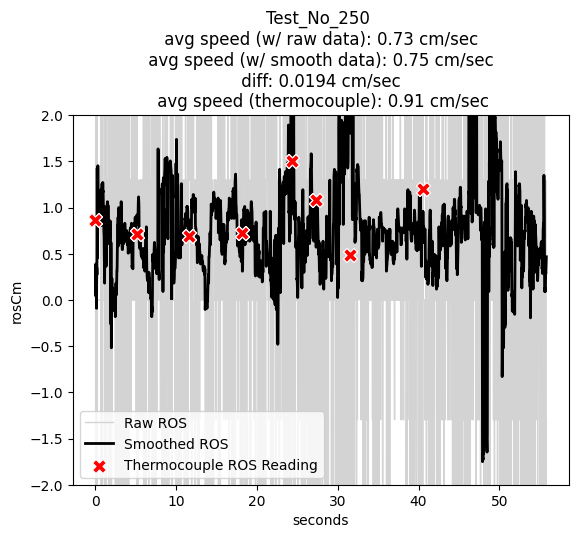

In [823]:
rosComparison = sns.lineplot(merged_df, x="seconds", y="rosCm", color="lightgrey", linewidth=1, label="Raw ROS")
rosComparison = sns.lineplot(merged_df, x="seconds", y="rosUsingSmoothXPosCm", color="black", linewidth=2, label="Smoothed ROS")
rosComparison = sns.scatterplot(merged_df, x="Ignition_time(sec)", y="ROS(cm/sec)", color="red", marker="X", s=100, zorder=10, label="Thermocouple ROS Reading")

avgSpeed = merged_df["rosCm"].mean()
avgSpeedUsingSmooth = merged_df["rosUsingSmoothXPosCm"].mean()
avgSpeedThermoCouple = merged_df["ROS(cm/sec)"].mean()

rosComparison.set_title(f"{testString} \n avg speed (w/ raw data): {avgSpeed:.2f} cm/sec \
\n avg speed (w/ smooth data): {avgSpeedUsingSmooth:.2f} cm/sec \
\n diff: {abs(avgSpeed - avgSpeedUsingSmooth):.4f} cm/sec \
\n avg speed (thermocouple): {avgSpeedThermoCouple:.2f} cm/sec")

rosComparison.set_ylim(-2, 2)

In [824]:
folderToSave = f"/Users/kyle/Library/CloudStorage/Box-Box/ROS_Experiments_Data_Folder/results/{testString}"

# Make folder if it doesn't exist
if not os.path.exists(folderToSave):
    os.makedirs(folderToSave)

# Save plots to files
posComparison.figure.savefig(f"{folderToSave}/posComparison.png", bbox_inches='tight')
rosComparison.figure.savefig(f"{folderToSave}/rosComparison.png", bbox_inches='tight')

# Simple version of merged_df
simple_merged_df = merged_df[["seconds", "highestXPosSmoothCm", "Ignition_time(sec)", "thermocouple_location(cm)",]]
# Rename columns
simple_merged_df.columns = ["video_seconds (sec)", "hsv_highestXPos_smooth (cm)", "thermocouple_Ignition_time (sec)", "thermocouple_location (cm)"]

# Save merged_df to CSV
simple_merged_df.to_csv(f"{folderToSave}/table.csv")